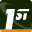  <font style="font-size:34px">&nbsp; <b>FIRST.org</b></font>

<h1>Follow the money!</h1>

This lesson will focus on ransomware and cryptocurrencies to introduce a some basic data science and statistical concepts. We'll look at a campaign called *Deadbolt*, and do some **survival analysis**. This term describes statistical methods that try to determine the duration of certain events. The name derives from biology where a common questions is how long does a population survive after a given event. The obvious question in incident response is how much time does it take from an initial compromise to full encryption. 

We then learn a surprising decryptor key mechanism. 

This tutorial is inspired by the good work we did in collaboration with Mark Ellzey @ censys.io. When you've finished the tutorial, go read some of the blogs listed at the bottom of this Lesson.

In [62]:
import pandas as pd
import json
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
from lifelines import KaplanMeierFitter, NelsonAalenFitter, WeibullFitter
from lifelines.utils import median_survival_times, datetimes_to_durations

We are going to analyse data about crypto payments related to the deadbold ransomware. The csv file contains transactions, i.e. the date, amount and wallets.

In [103]:
#Get the data on all ransoms paid
family_ransoms = pd.read_csv('data/DeadBolt_Accounts_RANSOMS.csv',index_col='confirmed_datetime',
                              parse_dates=['confirmed_datetime','received_datetime'],
                              date_format='ISO8601', low_memory=False)
family_ransoms.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 530 entries, 2022-02-14 16:17:04+00:00 to 2022-01-26 15:29:45+00:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   #trxnhash          530 non-null    object             
 1   trxntype           530 non-null    object             
 2   received_datetime  530 non-null    datetime64[ns, UTC]
 3   sending_address    530 non-null    object             
 4   receiving_address  530 non-null    object             
 5   BTC                530 non-null    float64            
 6   EUR                530 non-null    float64            
 7   USD                530 non-null    float64            
 8   count              530 non-null    int64              
 9   family             530 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(5)
memory usage: 45.5+ KB


Since we're interested in analysing temporal behavior we sort the data frame after the received time, which is closer to the infection date that the confirmed time, which indicates when the transaction completed. SO here we make an assumption, namely that the received time somehow correlates with the infection time. That's the best we can do without having to analyse each of the incidents in detail. This is a plausible assumption, but bey no means solid. 

In [64]:
family_ransoms = family_ransoms.sort_values('received_datetime')

Mark provided a json file containing the number of infections at a given date.

In [65]:
#Infection data from Censys.io
deadbolt_infections = [
  {
    "d": "2022-01-24",
    "count": "1"
  },
  {
    "d": "2022-01-25",
    "count": "4142"
  },
  {
    "d": "2022-01-26",
    "count": "4988"
  },
  {
    "d": "2022-01-27",
    "count": "3927"
  },
  {
    "d": "2022-01-28",
    "count": "2002"
  },
  {
    "d": "2022-01-29",
    "count": "1128"
  },
  {
    "d": "2022-01-30",
    "count": "920"
  },
  {
    "d": "2022-01-31",
    "count": "853"
  },
  {
    "d": "2022-02-01",
    "count": "783"
  },
  {
    "d": "2022-02-02",
    "count": "735"
  },
  {
    "d": "2022-02-03",
    "count": "712"
  },
  {
    "d": "2022-02-04",
    "count": "656"
  },
  {
    "d": "2022-02-05",
    "count": "627"
  }
]

Convert this to a dataframe (what else?)>

In [66]:
infection_timeseries = pd.DataFrame( deadbolt_infections,  )
infection_timeseries.rename( { 'd' : 'Date' , 'count' : 'Count'} , inplace=True,axis=1)
infection_timeseries['Date'] = pd.to_datetime( infection_timeseries['Date'] )
infection_timeseries = infection_timeseries.astype( {'Count': 'int64'})

infection_timeseries.set_index('Date', inplace=True)
infection_timeseries.head()

,Count
Date,
2022-01-24,1
2022-01-25,4142
2022-01-26,4988
2022-01-27,3927
2022-01-28,2002


## A crash course in statistics

Now let's do a little science and test something that should be intuitive. Does the number of infections correlate to the number of ransoms paid (numerically speaking). We'll need to talk a little about **the null hypothesis** is that they do not.

In statistics the **the null hypothesis $H_0$** is the claim that two variables are not correlated, i.e. their relationship is truly random. For example a given drug has zero effect on some medical condition. Thus out job is to show that the null hypothesis is wrong.

### Correlation

In statistics **correlation** is a number indicating how strong the relation between two data sets is. There are different definitions but the most common one is **Pearson coefficient**, a number between -1 and 1. ! means positive correlation, i.e. if one number grows so does the other, and -1 is negative correlation indication that as one number grows the other decreases. For example height correlates with weight. A correlation of 0 says the two number do not correlate.

 > Correlation does not imply causation! For example the number of storks and the number of births are correlated: [Do Storks Deliver Babies?](https://priceonomics.com/do-storks-deliver-babies/)

For completeness sake the formula for the Pearson correlation of a dataset $[ (x_1, y_1), ... (x_n, y_n)]$ is
$$
  r = \frac{n ( \Sigma x y ) - (\Sigma x)(\Sigma y)}{ \sqrt{ (  n \Sigma x^2 - (\Sigma x)^2 ) (  n \Sigma y^2 - (\Sigma y)^2 ) }}
$$

where the sum runs from 1 to n. Don't worry too much about the actual formula though. 

But how much does the r value mean? If you only have only few data points anything is possible. This is where the **p-value** enters the game, it tells you how likely the given data set rejects the null hypothesis, i.e. how what the likely hood is that the given correlation is not just a coincidence. The definition of the p-value is 

> *the probability that the data set has the given correlation assuming the $H-0$ is true.  

Thus the lower the p-value the more likely the correlation is true. Typically people are happy with a p-value of less than 0.05 or 0.01 (5% or 1%).

The article [Correlation and P value](https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/) gives a nice introductions. 

Luckily the `scipy` package does all the work for us. 

To summarize:

- A low p-value **rejects the null hypothesis**
- The correlation $r$ tells us **how strongly** the data is correlated.

Let us now apply this to our data.  `family_ransoms` contains a list of ransowmare events, so we have to bin then. the Pandas function `resample` dies this for us, with the parameter `D` indicating to create bins of one day. The infection_time series only has the first 13 days, so we just cut the data of there. 

Then we feed the whole thing to `pysci.pearsonr` et voila:


In [67]:
#Note this is a one day lag correlation
corr, p_value = pearsonr(infection_timeseries['Count'], family_ransoms['count'].resample('D').sum().head(13))
print('Pearsons correlation: %.3f' % corr)
print('P-value is: %.10F' % p_value)

Pearsons correlation: 0.876
P-value is: 0.0000848383


So trying to sum up our result into a single scientific sentence:
We can reject the null hypothesis that ransoms don't correlate with infections.
Or in more plain English:
There's less than a 1% chance of our scientific result occuring by accident.
So, More infections = more ransoms paid.

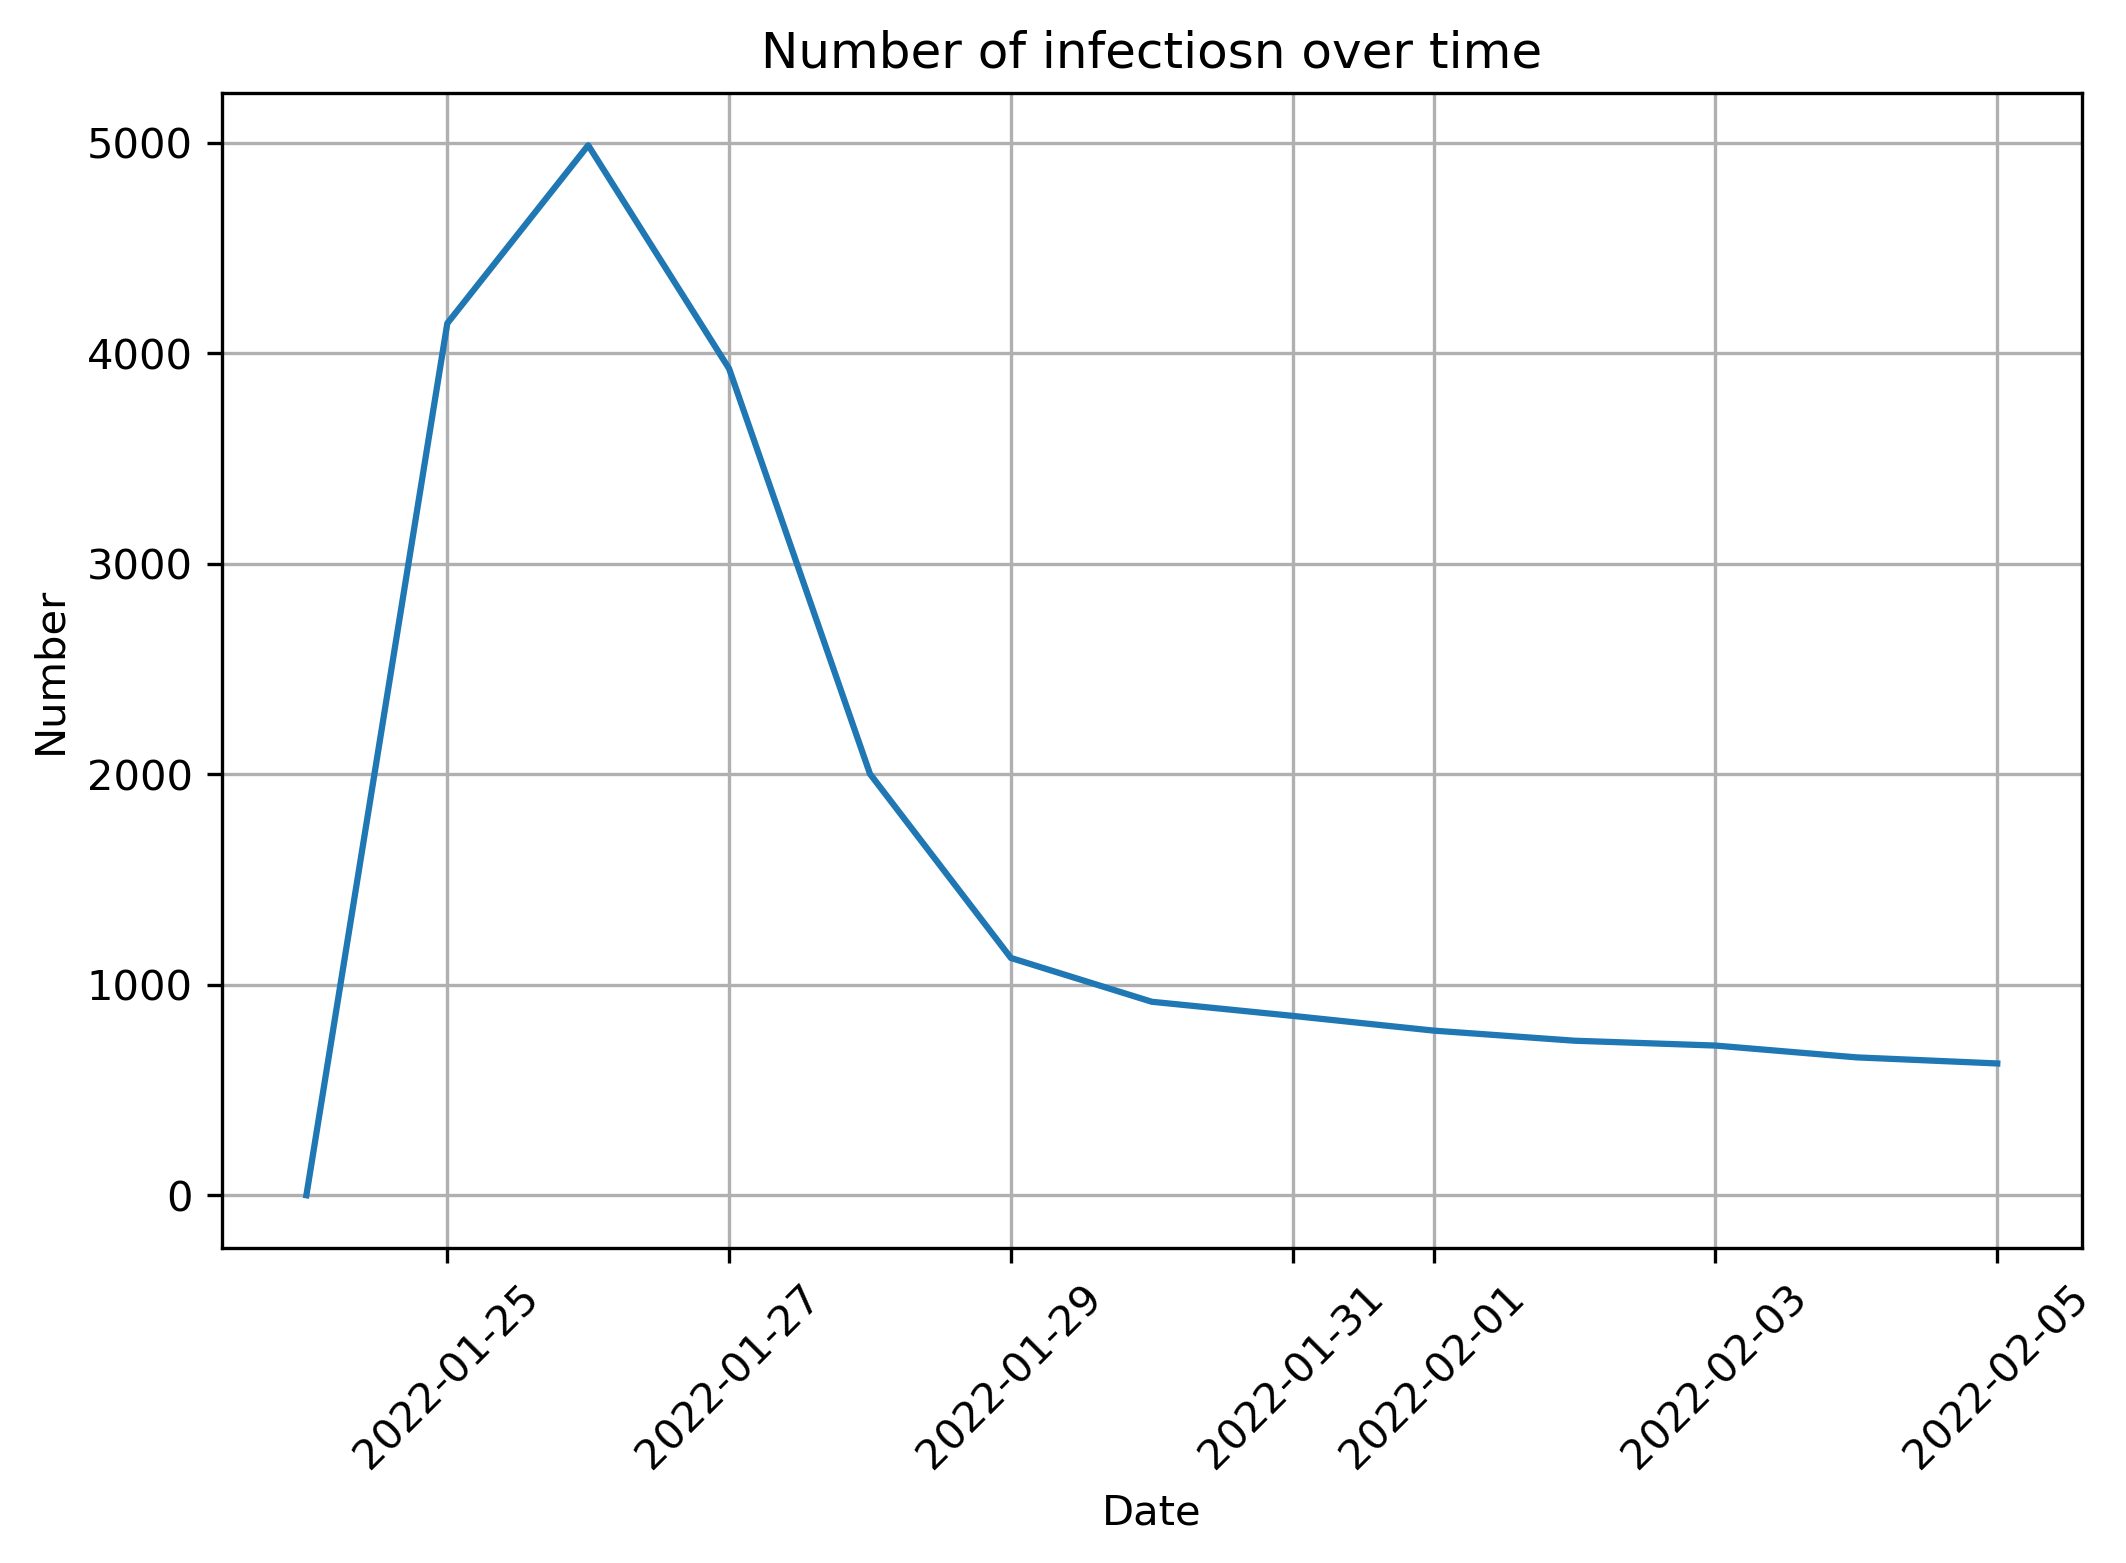

In [120]:
#Let's look at how the infections change over time
fig, ax = plt.subplots() 
ax.plot(infection_timeseries.index,infection_timeseries['Count'], label = "Infections")
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Number of infectiosn over time")
ax.set_xlabel( "Date" )
ax.set_ylabel("Number")
ax.grid()


Sometimes you need a certain number over and over again. So just define it at one place, but don't forget to change it if you get new data, i.e. you learn about new infections. In our example the number of days for which we have data is such a number. It has no statistical meaning, it's just convenience here. 

In [71]:
num_days = len(family_ransoms['count'].resample('D').sum())
num_days

498

Let's have a look at the ransoms payed as time goes on

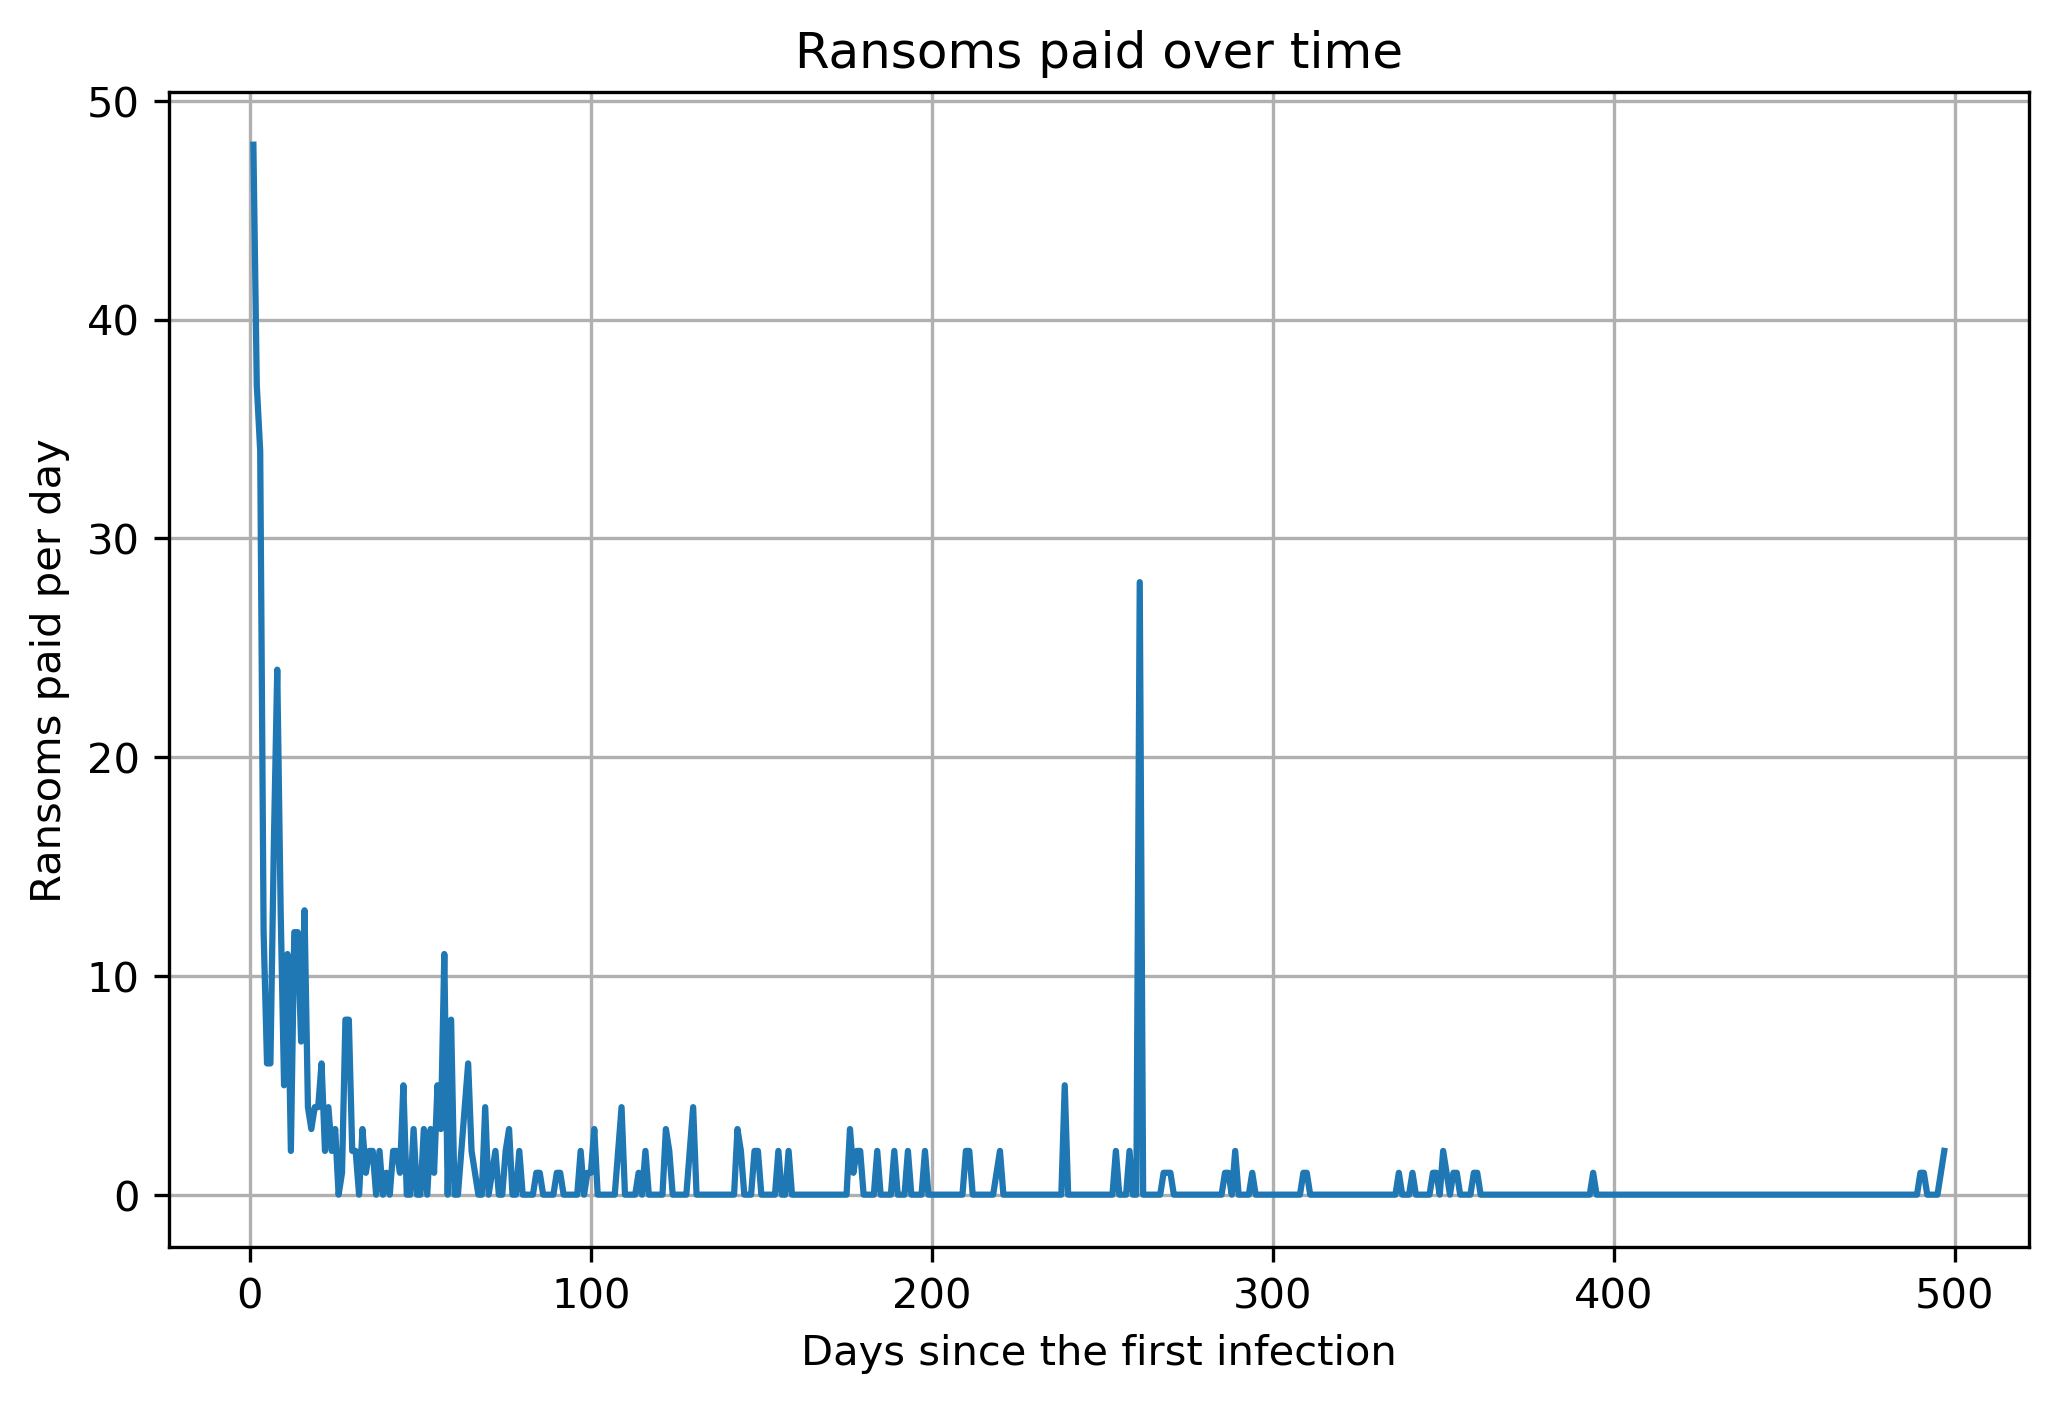

In [78]:
#Let's look at ransoms paid over time
fig, ax = plt.subplots() 
ax.plot(np.arange(1,num_days,1),family_ransoms.resample('D').sum()['count'][1:], label = "Ransoms")
ax.set_xlabel('Days since the first infection')
ax.set_ylabel('Ransoms paid per day')
ax.grid()
_ = ax.set_title("Ransoms paid over time")

## Payments over time

In [123]:
max_daily_infections = max(infection_timeseries['Count'])
print("Maximum daily infections", max_daily_infections )
payment_list = family_ransoms['received_datetime'].dt.date.to_list()
non_payment_list = [None]*(max_daily_infections-len(payment_list))
full_list = payment_list + non_payment_list
d = {'infection' : ['2022-01-24']*max_daily_infections,
     'payment'   : full_list}
survival_analysis = pd.DataFrame(d)
survival_analysis

Maximum daily infections 4988


,infection,payment
0,2022-01-24,2022-02-14
1,2022-01-24,2022-02-15
2,2022-01-24,2022-02-05
3,2022-01-24,2022-02-04
4,2022-01-24,2022-04-06
...,...,...
4983,2022-01-24,None
4984,2022-01-24,None
4985,2022-01-24,None
4986,2022-01-24,None


Text(0, 0.5, 'Proportion of infection who did not pay ransom')

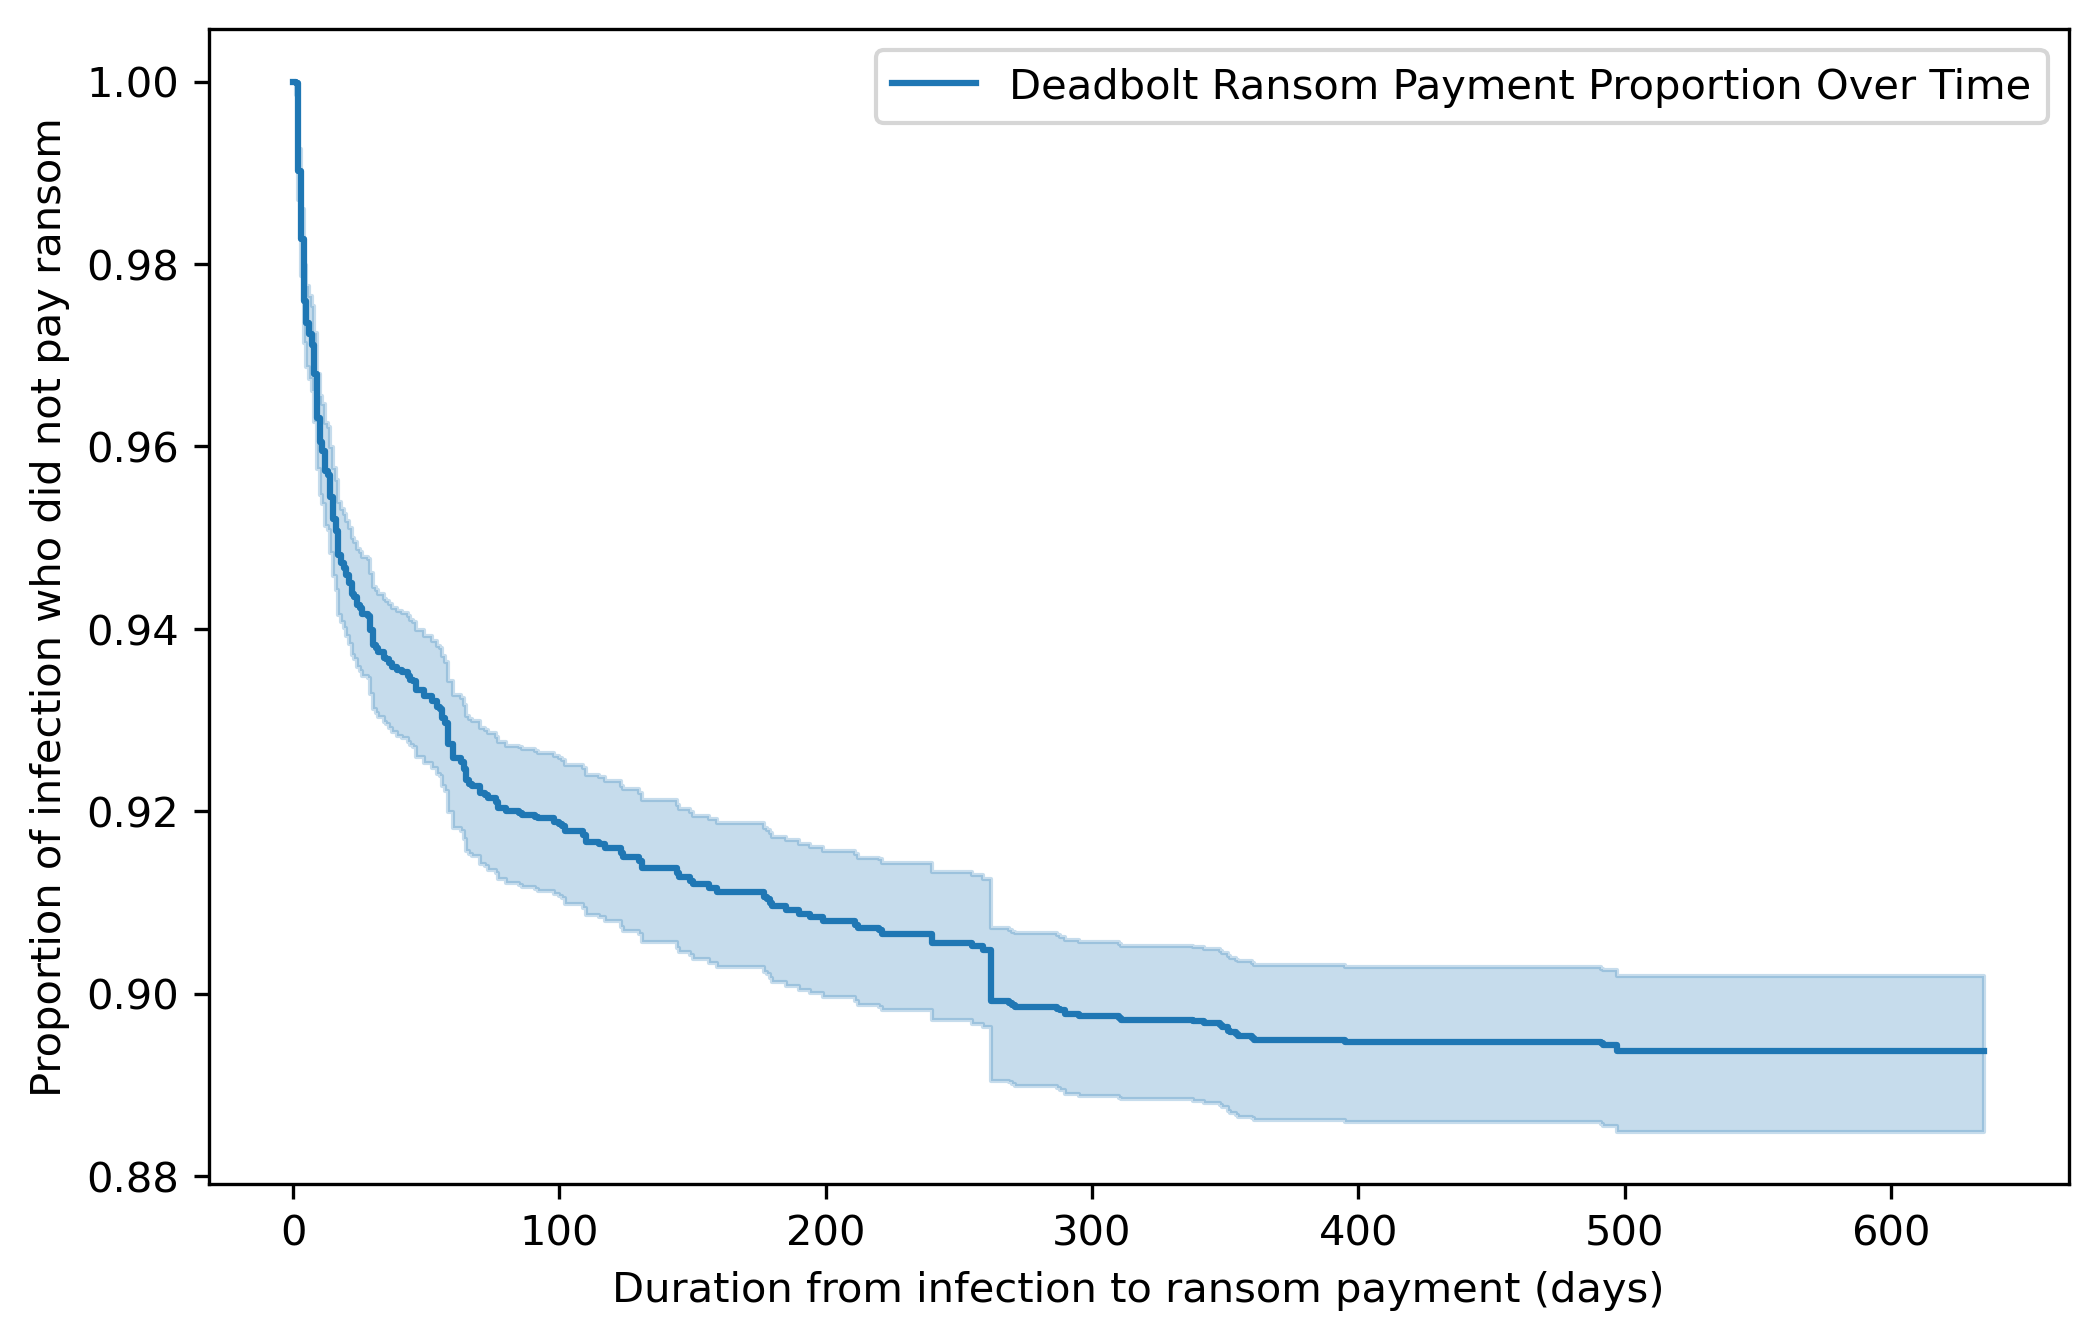

In [115]:
kmf = Kaplan-Meier estimate ()
survival_analysis = survival_analysis.reset_index()
survival_analysis = survival_analysis[['infection','payment']]
T, E = datetimes_to_durations(survival_analysis['infection'], survival_analysis['payment'], freq='D')
kmf.fit(T, E, label='Deadbolt Ransom Payment Proportion Over Time')
kmf.plot()
plt.xlabel('Duration from infection to ransom payment (days)')
plt.ylabel('Proportion of infection who did not pay ransom')

In [16]:
kmf.confidence_interval_

,Deadbolt Ransom Payment Proportion Over Time_lower_0.95,Deadbolt Ransom Payment Proportion Over Time_upper_0.95
0.0,1.000000,1.000000
1.0,0.998578,0.999972
2.0,0.987023,0.992567
3.0,0.978744,0.986020
4.0,0.971297,0.979844
...,...,...
395.0,0.885900,0.902947
491.0,0.885693,0.902754
492.0,0.885485,0.902560
497.0,0.884863,0.901981


In [19]:
# Get the data on all transactions
# There's a very interesting BTC address in here, that both sends and recieves. Can you figure out which one?
find_the_interesting_address = pd.read_csv('data/DeadBolt_Accounts_TRXNS.csv',index_col='confirmed_datetime',parse_dates=['confirmed_datetime','received_datetime'],low_memory=False)

In [ ]:
# Now you may need to look at other sources than just this notebook to figure out what is going on. 
# Use the address in a blockchain explorer, and see if you can understand what is in the the OP_RETURN fields of 
# transactions to that address

Mark's [initial post](https://censys.com/tracking-deadbolt-ransomware-across-the-globe/), where he contacted me to follow the money.
Mark's [follow up](https://censys.com/the-neverending-story-of-deadbolt/) work with his own data science team.
The data science team at Censys made it easy to [track infections](https://lookerstudio.google.com/reporting/f8d38b6c-9997-4bba-be93-19cf57d7371a/page/p_dxblu6m2uc). Which is a practical and real world example of how jupyter notebooks and collaboration helps incident response.